In [11]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [12]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e6  # Big M

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1]*_exec_scenarios

In [13]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=0.00,
                    label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')

com1_stored10 = Resource(name='com1_stored10', store_max=10, label='Commodity 1 in storage10')
com1_stored20 = Resource(name='com1_stored20', store_max=20, label='Commodity 1 in storage20')
com1_stored50 = Resource(name='com1_stored50', store_max=50, label='Commodity 1 in storage50')

com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [14]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=M, conversion={com1_pur: -1, com1_in: 1}, capex=0, vopex=0, fopex=0,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0, vopex=0, fopex=0,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=M, conversion={com1_loc1_out:-1, com1_in:1}, capex=0, vopex=0, fopex=0,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=M, conversion={com1_loc2_out:-1, com1_in:1}, capex=0, vopex=0, fopex=0,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=M, conversion={com1_loc3_out:-1, com1_in:1}, capex=0, vopex=0, fopex=0,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=M, conversion={com1_loc4_out:-1, com1_in:1}, capex=0, vopex=0, fopex=0,
                            label='Commodity 1 received from location 4')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=M, conversion={com1_loc6_out:-1, com1_in:1}, capex=0, vopex=0, fopex=0,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=M, conversion={com1_loc7_out:-1, com1_in:1}, capex=0, vopex=0, fopex=0,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=M, conversion={com1_in:-1, com1_out:1}, capex=0, vopex=0, fopex=0,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', conversion={com1_in:-1, com1_stored10:1}, store_max=10/_coms, prod_max=M, capex=100, vopex=1,
                  label="Storage capacity of 10 units")
com1_discharge10 = Process(name='com1_discharge10', conversion={com1_stored10:-1, com1_out:1}, 
                                 label='Discharge process from storage')

com1_store20 = Process(name='com1_store20', conversion={com1_in:-1, com1_stored20:1}, store_max=20/_coms, prod_max=M, capex=200, vopex=2,
                  label="Storage capacity of 20 units")
com1_discharge20 = Process(name='com1_discharge20', conversion={com1_stored20:-1, com1_out:1}, 
                                 label='Discharge process from storage')

com1_store50 = Process(name='com1_store50', conversion={com1_in:-1, com1_stored50:1}, store_max=50/_coms, prod_max=M, capex=500, vopex=5,
                  label="Storage capacity of 50 units")
com1_discharge50 = Process(name='com1_discharge50', conversion={com1_stored50:-1, com1_out:1}, 
                                 label='Discharge process from storage')

com1_loc1_send = Process(name='com1_loc1_send', prod_max=M, conversion={com1_out:-1, com1_loc1_out:1}, capex=0, vopex=0, fopex=0,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=M, conversion={com1_out:-1, com1_loc2_out:1}, capex=0, vopex=0, fopex=0,
                            label='Send commodity one from location 1')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=M, conversion={com1_out:-1, com1_loc3_out:1}, capex=0, vopex=0, fopex=0,
                            label='Send commodity one from location 1')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=M, conversion={com1_out:-1, com1_loc4_out:1}, capex=0, vopex=0, fopex=0,
                            label='Send commodity one from location 1')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=M, conversion={com1_out:-1, com1_loc6_out:1}, capex=0, vopex=0, fopex=0,
                            label='Send commodity one from location 1')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=M, conversion={com1_out:-1, com1_loc7_out:1}, capex=0, vopex=0, fopex=0,
                            label='Send commodity one from location 1')


In [15]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_process, com1_store20, com1_discharge20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge50, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_process, com1_store50, com1_discharge50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_discharge50, com1_sell,}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_process, com1_store10, com1_discharge10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_process, com1_store20, com1_discharge20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

In [16]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20 = Transport(name='truck20', resources=[com1_loc3_out], trans_max=20, label='Truck with maximum capacity of 20 units', capex=20, vopex=0.02)
truck30 = Transport(name='truck30', resources=[com1_loc1_out, com1_loc2_out], trans_max=30, label='Truck with maximum capacity of 30 units', capex=30, vopex=0.03)
truck40 = Transport(name='truck40', resources=[com1_loc4_out, com1_loc7_out], trans_max=40, label='Truck with maximum capacity of 40 units', capex=40, vopex=0.04)
truck50 = Transport(name='truck50', resources=[com1_loc1_out, com1_loc2_out, com1_loc6_out], trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05)
truck100 = Transport(name='truck100', resources=[com1_loc4_out], trans_max=100, label='Truck with maximum capacity of 100 units', capex=100, vopex=0.1)

In [17]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50], [truck30], [], [], [], []],  # sink: location 1
    [[truck50], [], [], [truck50], [truck30], [], []],  # sink: location 2
    [[truck30], [], [], [truck20], [], [], []],  # sink: location 3
    [[], [truck50], [truck20], [], [truck100], [truck50], [truck40]],  # sink: location 4
    [[], [truck30], [], [truck100], [], [], [truck40]],  # sink: location 5
    [[], [], [], [truck50], [], [], []],  # sink: location 6
    [[], [], [], [truck40], [truck40], [], []]  # sink: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [18]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 125} if i == loc5 else {com1_sold: 0} for i in locset}
min_demand_satisfaction = 0.20
min_demand_dict = {i: {com1_sold: min_demand_satisfaction*100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption = Scenario(name='scenario_disruption', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='scenario_disruption')

In [19]:
problem_mincost = formulate(scenario=scenario_disruption,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                         Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty


In [20]:
results_mincost = solve(scenario=scenario_disruption, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 349301 rows, 851707 columns and 751575 nonzeros
Model fingerprint: 0x9972b47a
Variable types: 851462 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Found heuristic solution: objective 4500000.0000
Presolve removed 336712 rows and 838743 columns
Presolve time: 0.42s
Presolved: 12589 rows, 12964 columns, 40635 nonzeros
Variable types: 12964 continuous, 0 integer (0 binary)

Root relaxation: objective 1.711968e+06, 9670 iterations, 0.71 seconds (1.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0   

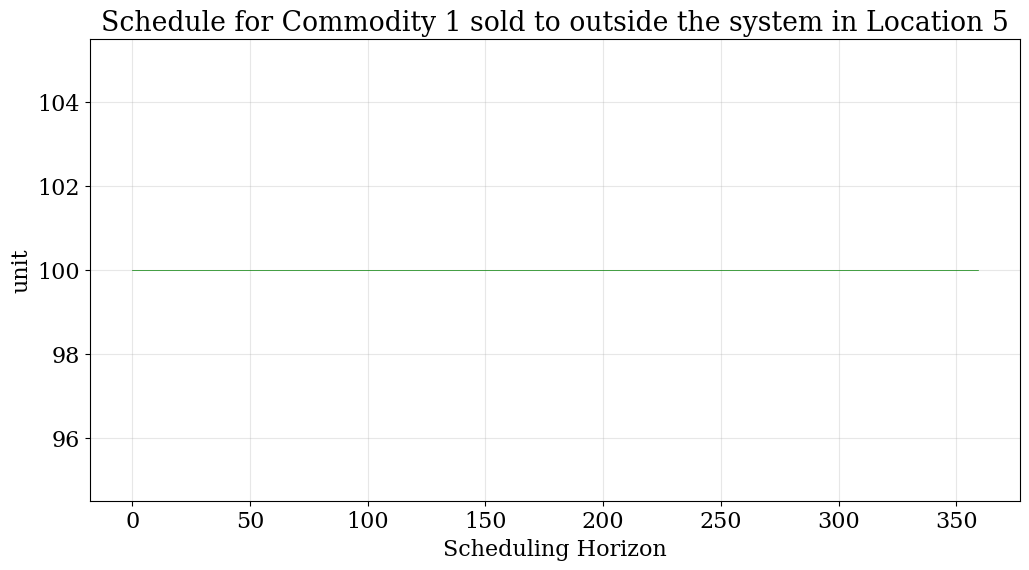

In [21]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

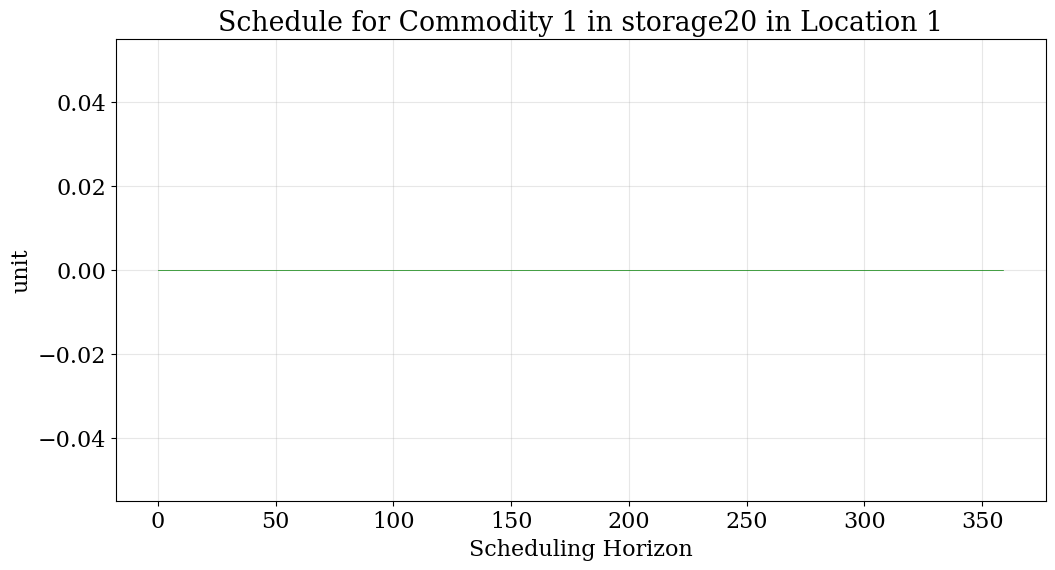

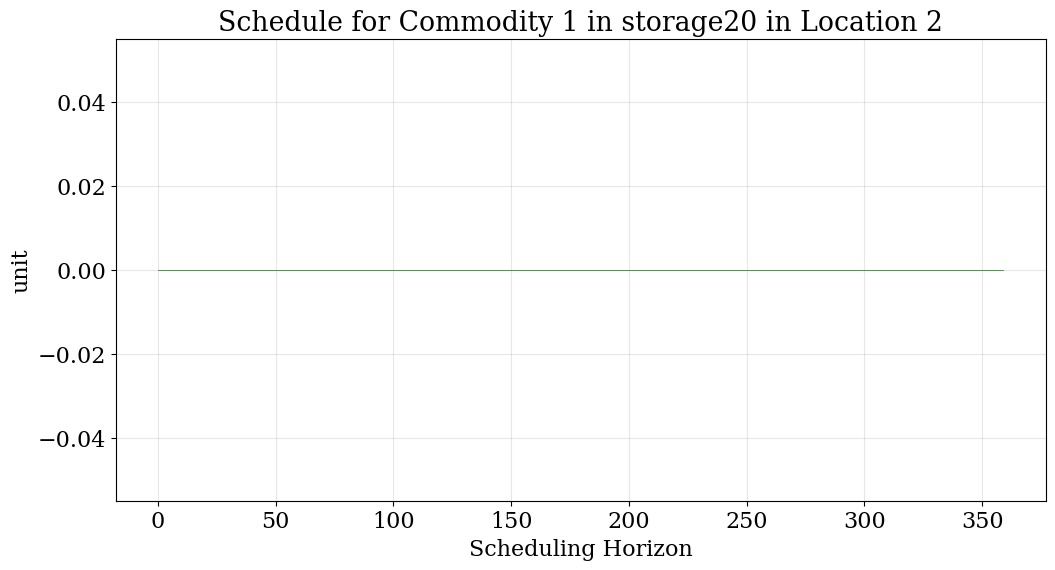

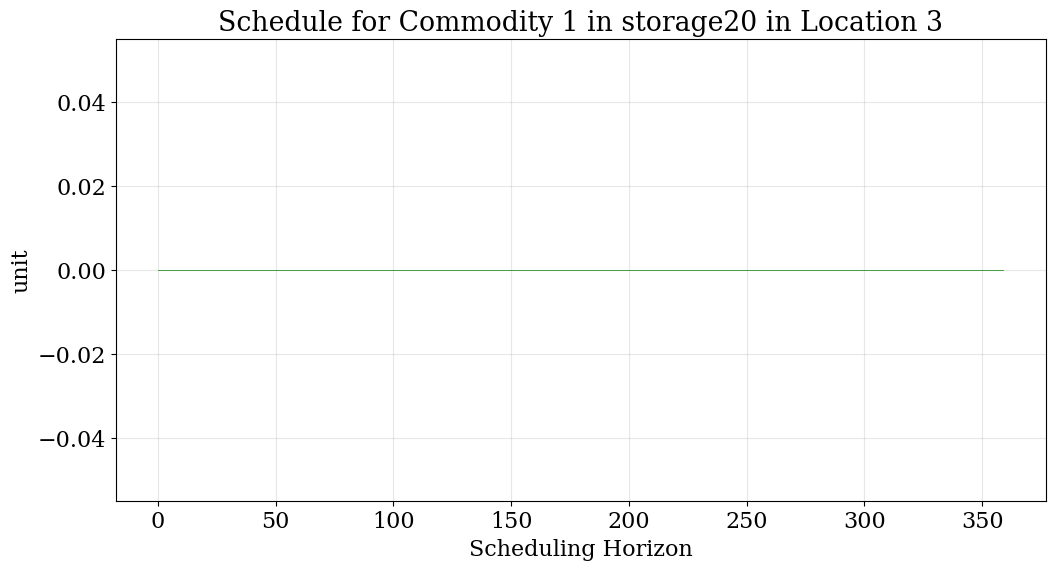

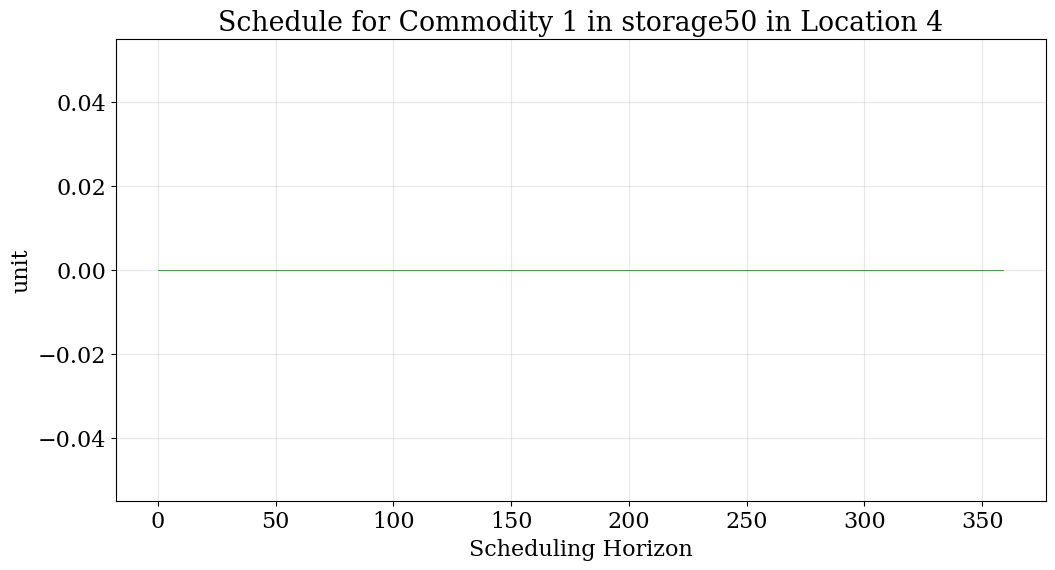

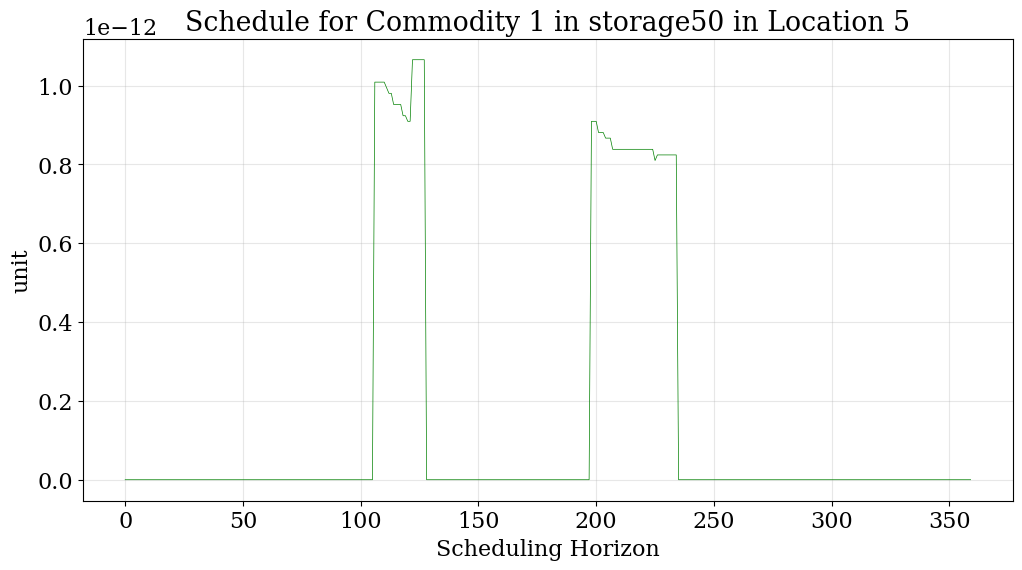

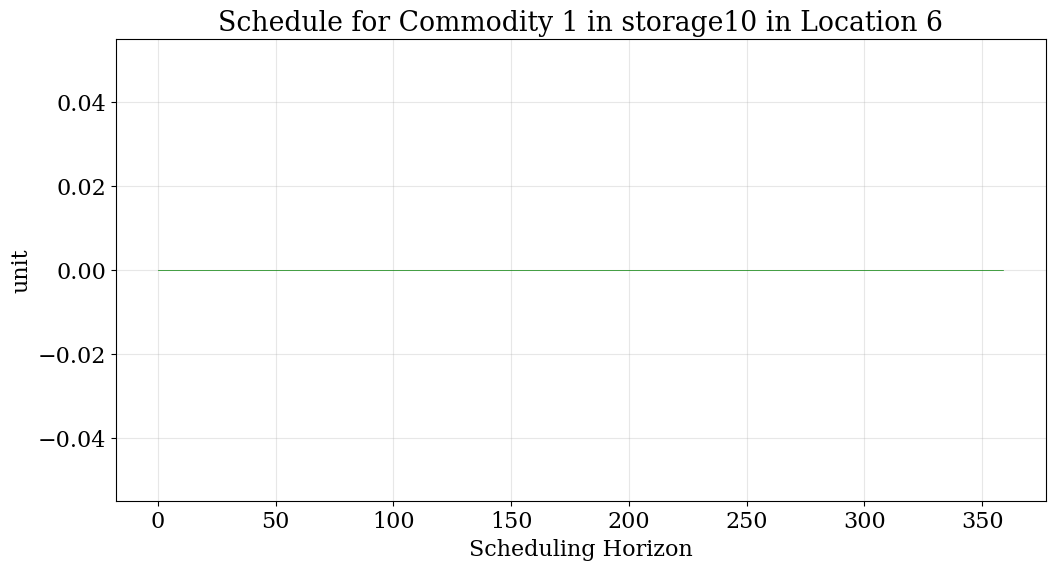

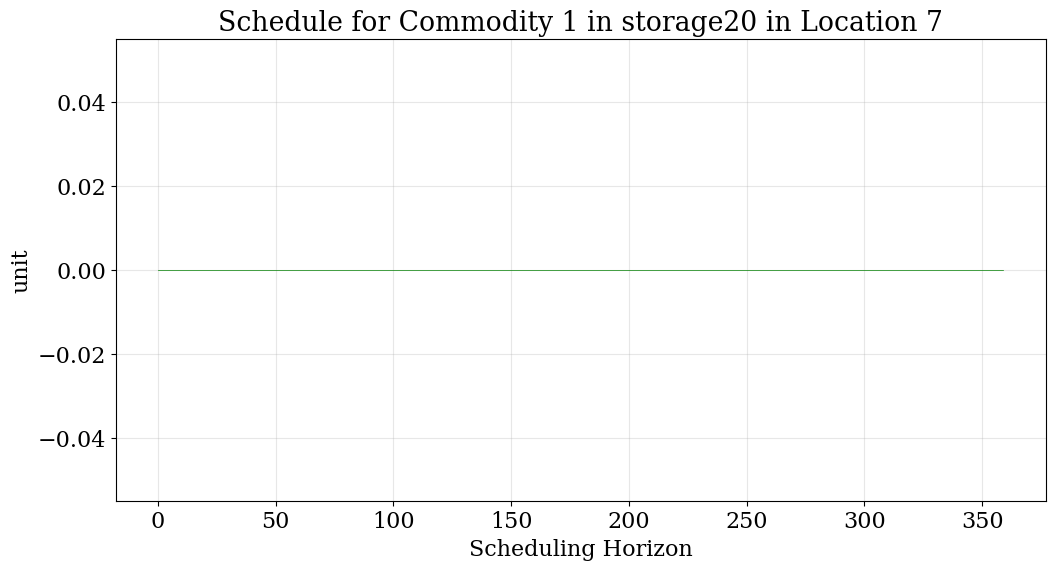

In [22]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored10', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc7', color='green')

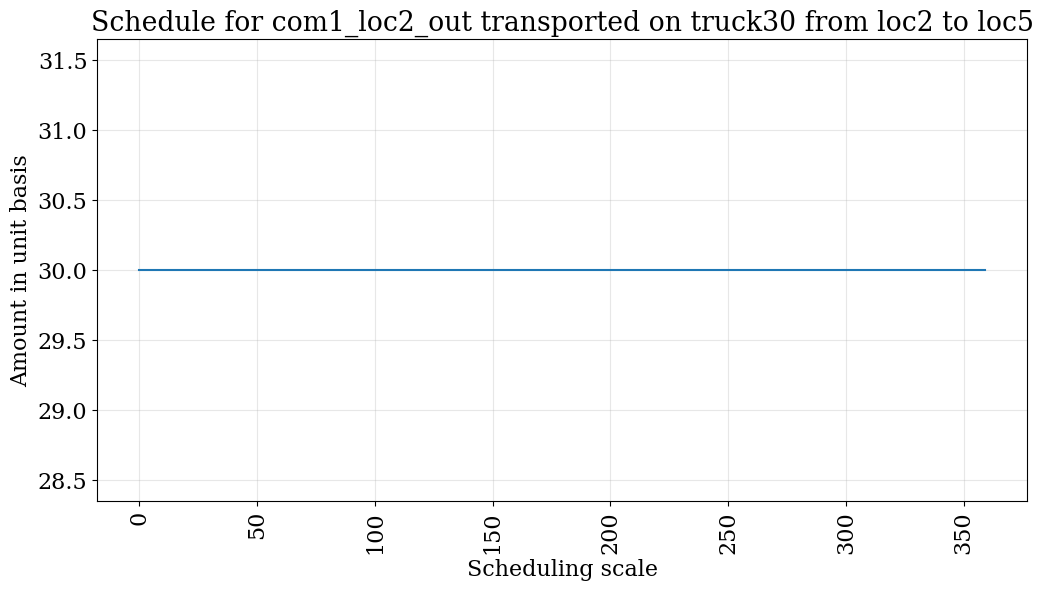

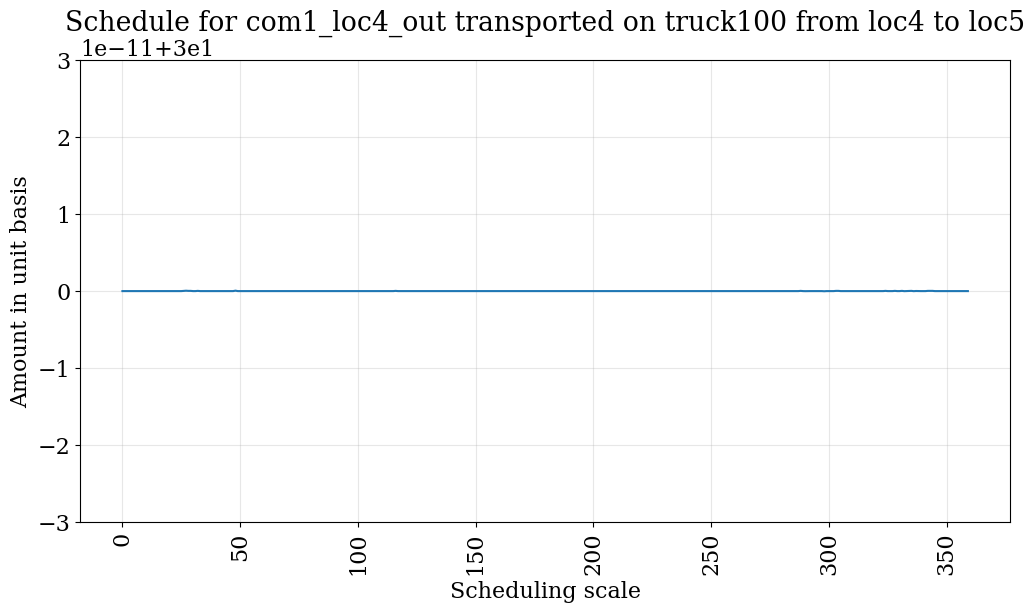

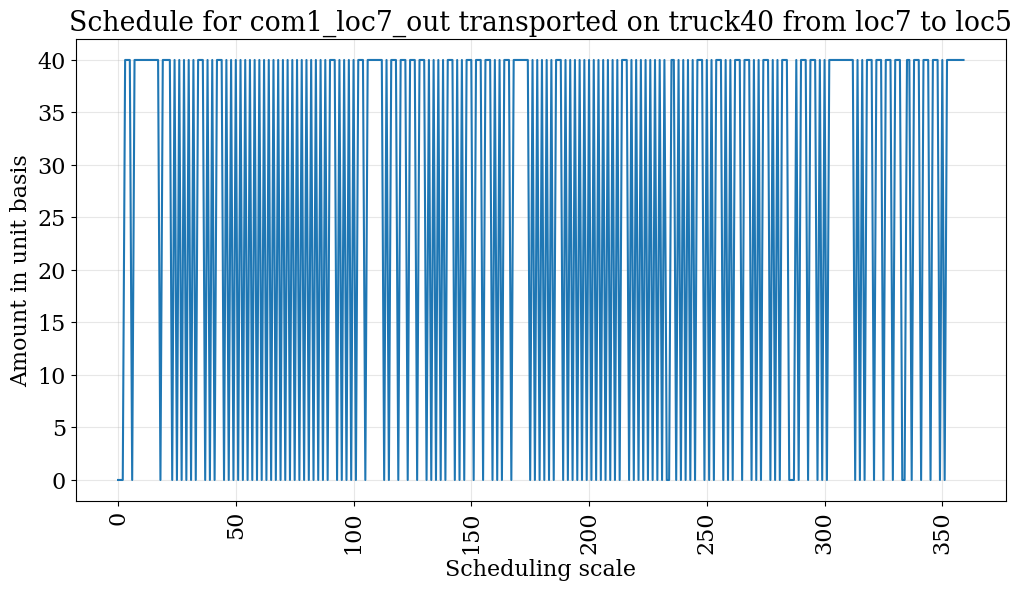

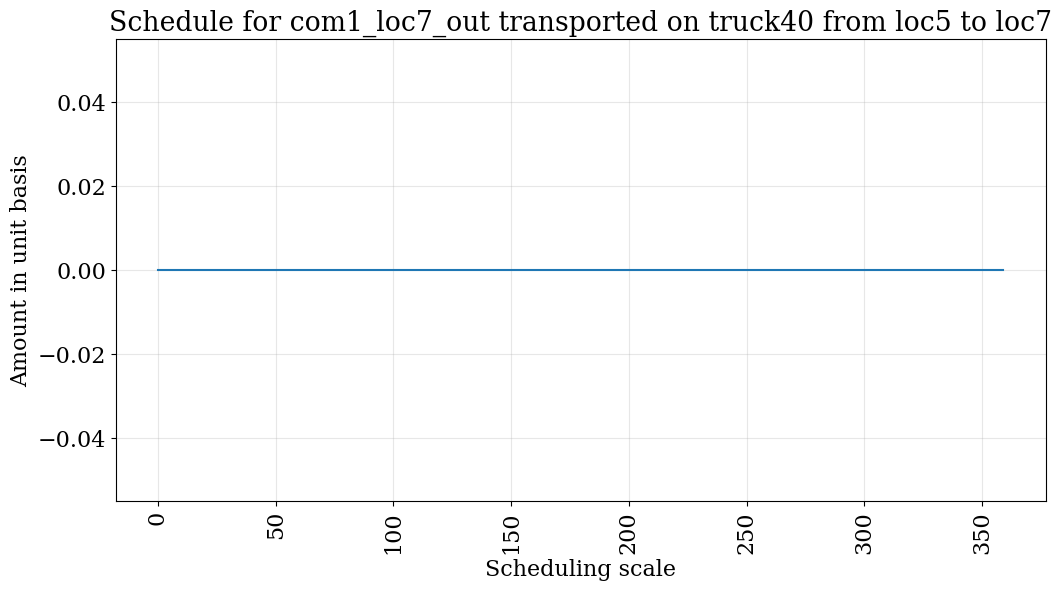

In [33]:

plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40',
                       resource='com1_loc7_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc7', transport='truck40',
                       resource='com1_loc7_out')

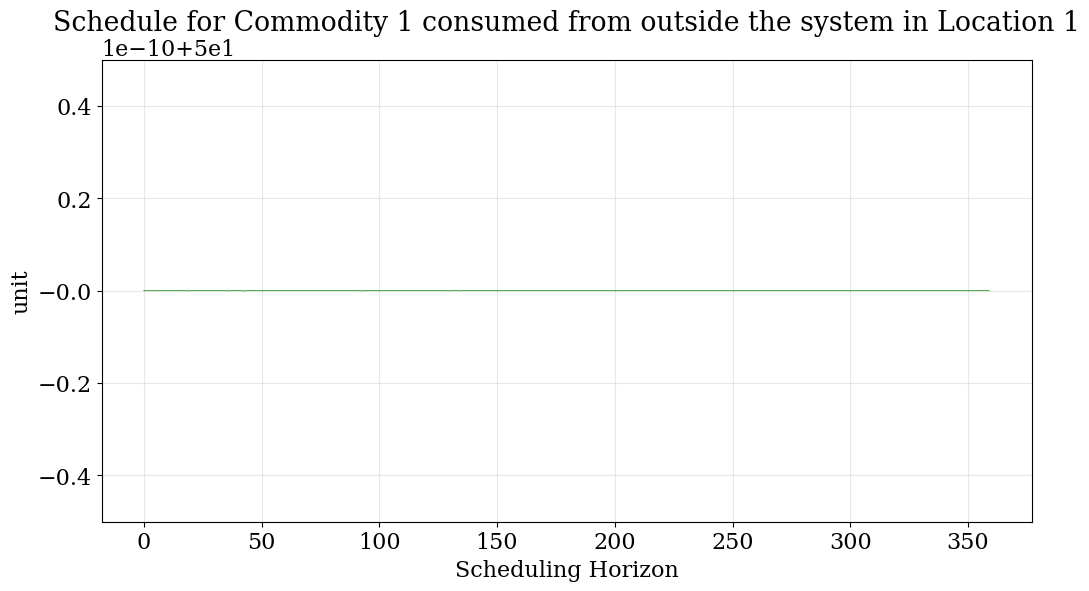

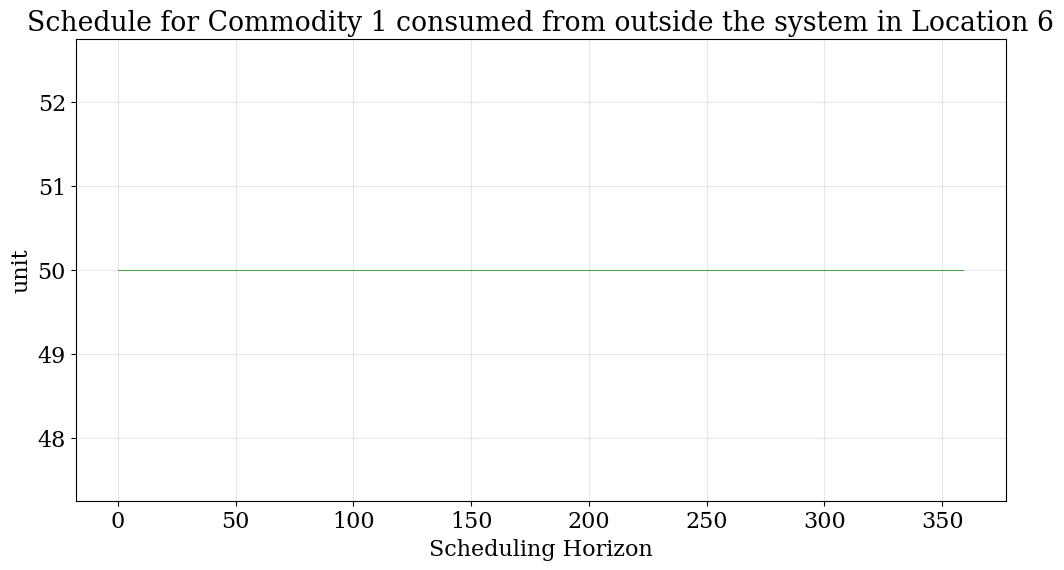

In [24]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

In [30]:
print([(key, value) for key, value in results_mincost.output['Exp'].items() if key[0]!='loc7' and key[0]!='loc1' and key[0]!='loc4' and key[1]=='loc5' and key[3]=='com1_loc7_out' and value!=0 and value!=None])

[]


In [44]:
problem_mincost.constraint_inventory_balance['loc5','com1_sold',0,0,0].pprint()

{Member of constraint_inventory_balance} : mass balance across scheduling scale
    Size=32760, Index=constraint_inventory_balance_index, Active=True
    Key                            : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [45]:
problem_mincost.constraint_export['loc7', 'loc5','truck40',0,0,0].pprint()

{Member of constraint_export} : capacity bound export of resource from source to sink
    Size=6480, Index=constraint_export_index, Active=True
    Key                                  : Lower : Body                                                        : Upper : Active
    ('loc7', 'loc5', 'truck40', 0, 0, 0) :  -Inf : Exp_F[loc7,loc5,truck40,0,0,0] - Cap_F[loc7,loc5,truck40,0] :   0.0 :   True


In [47]:
problem_mincost.Cap_F.pprint()

Cap_F : established capacity of transport mode
    Size=245, Index=Cap_F_index
    Key                             : Lower : Value              : Upper : Fixed : Stale : Domain
    ('loc1', 'loc1', 'truck100', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
     ('loc1', 'loc1', 'truck20', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
     ('loc1', 'loc1', 'truck30', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
     ('loc1', 'loc1', 'truck40', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
     ('loc1', 'loc1', 'truck50', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
    ('loc1', 'loc2', 'truck100', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
     ('loc1', 'loc2', 'truck20', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
     ('loc1', 'loc2', 'truck30', 0) :     0 :                0.0 : 

In [49]:
problem_mincost.X_F.pprint()

X_F : binaries for transports being set up
    Size=245, Index=X_F_index
    Key                             : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc1', 'loc1', 'truck100', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc1', 'truck20', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc1', 'truck30', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc1', 'truck40', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc1', 'truck50', 0) :     0 :  None :     1 : False :  True : Binary
    ('loc1', 'loc2', 'truck100', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc2', 'truck20', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc2', 'truck30', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc2', 'truck40', 0) :     0 :  None :     1 : False :  True : Binary
     ('loc1', 'loc2', 'truck50', 0) :     0 :   1.0 :     1 : False : False :